# CNN Implementation #

In [1]:
import os

import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from keras import backend as K
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

## With out K-fold or Feature extraction, use validation set only ##
Update: We are testing this method with W9 data

## load real dataset ##
Dont be sad if it does not fit, at least it is real
This dataset is for w11, contains mermaid : 0, jamesbond: 1, dab:2

In [6]:
# data_folder_path_0 = os.path.join(os.getcwd(), 'w11_joshua_1')
# data_folder_path_1 = os.path.join(os.getcwd(), 'w11_joshua_2')
# data_folder_path_2 = os.path.join(os.getcwd(), 'w11_sanath_1')
# data_folder_path_3 = os.path.join(os.getcwd(), 'w11_michael_1')
# folders = glob(os.path.join(data_folder_path,'*.csv'))
# folders = glob(os.path.join(data_folder_path,'*.csv'))
# folders_2 = glob(os.path.join(data_folder_path_2,'*.csv'))
# folders_3 = glob(os.path.join(data_folder_path_3,'*.csv'))
activity_codes = {'mermaid':0,'jamesbond':1,'dab':2}
activity_decodes = {0:'mermaid',1:'jamesbond',2:'dab'}
#usr_cols = ['attitude.roll','attitude.pitch','attitude.yaw','userAcceleration.x','userAcceleration.y','userAcceleration.z']
activity_types = list(activity_codes.keys())

#hyper parameters
# window size is 3 s, sample rate 20 Hz
# Sliding window
window = 40
frequency = 20
cut_size_cand = 30
distinct_in_overlap = 10
overlap = int(((window - distinct_in_overlap) / window) * 100)
print(overlap)
#exponential moving average
ema = True
com = 2
#simple moving average
sma = False
sma_window = 3
# We need to skip the first trial
n_trials = 6
# We skip tial if it is less than the window length. How many we have?
skip_c = 0
# from col 1 to 6: Accelerometer x, y, z, yall, pitch, roll
usr_cols = ['1','2','3','4','5','6']
drop_cols = ['0', 'Unnamed: 0']
feature_n = 6

75


###  study data set ###

(6483, 8)
(6582, 8)


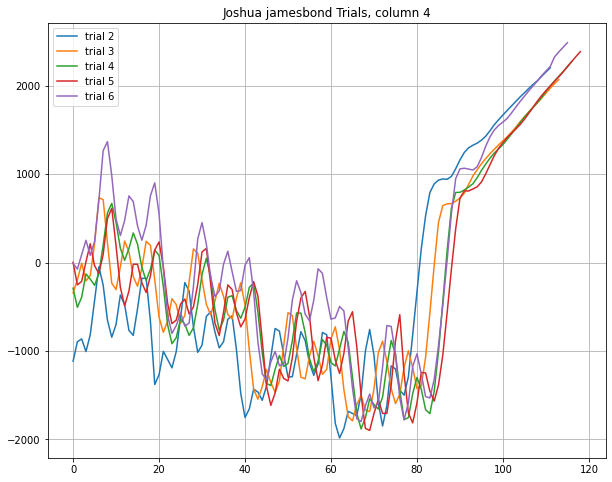

In [23]:
test_data = pd.read_csv(os.path.join(data_folder_path, 'jamesbond_josh.csv'), index_col = False)
print(test_data.shape)
test_data_2 = pd.read_csv(os.path.join(data_folder_path_2, 'jamesbond_sanath.csv'), index_col = False)
print(test_data_2.shape)

fig, ax = plt.subplots(figsize = [10,8])
for i in range(2,7):
    temp = test_data[test_data['0'] == i]
    x = [i for i in range(temp.shape[0])]
    ax.plot(x, temp['4'], label = f"trial {str(i)}")
#     temp = temp.ewm(com = 2).mean()
#     ax.plot(x, temp['4'], label = f"trial after EMA {str(i)}")

plt.title('Joshua jamesbond Trials, column 4')
plt.legend()
ax.grid()
plt.show()

(6582, 8)


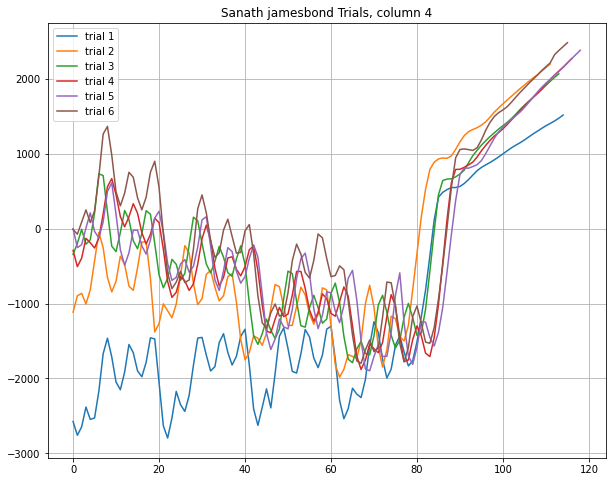

In [7]:
test_data_2 = pd.read_csv(os.path.join(data_folder_path_2, 'jamesbond_sanath.csv'), index_col = False)
print(test_data_2.shape)

fig, ax = plt.subplots(figsize = [10,8])
for i in range(1,7):
    temp = test_data[test_data['0'] == i]
    x = [i for i in range(temp.shape[0])]
    ax.plot(x, temp['4'], label = f"trial {str(i)}")
#     temp = temp.ewm(com = 2).mean()
#     ax.plot(x, temp['4'], label = f"trial after EMA {str(i)}")

plt.title('Sanath jamesbond Trials, column 4')
plt.legend()
ax.grid()
plt.show()

(5498, 8)


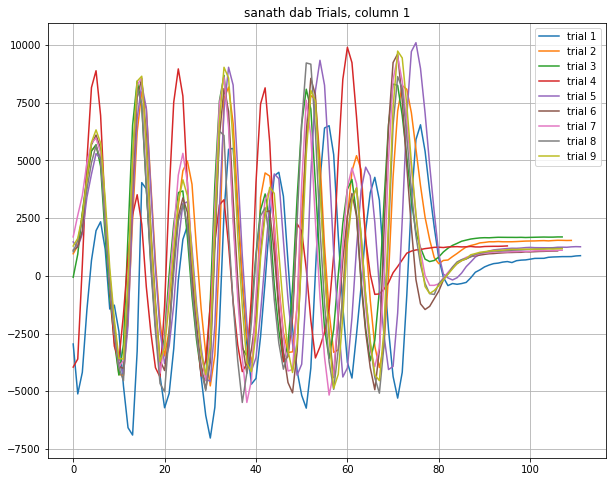

In [22]:
test_data_3 = pd.read_csv(os.path.join(data_folder_path_2, 'dab_sanath.csv'), index_col = False)
print(test_data_3.shape)

fig, ax = plt.subplots(figsize = [10,8])
for i in range(1, 10):
    temp = test_data_3[test_data_3['0'] == i]
    x = [i for i in range(temp.shape[0])]
    ax.plot(x, temp['1'], label = f"trial {str(i)}")

plt.title('sanath dab Trials, column 1')
plt.legend()
ax.grid()
plt.show()

(5505, 8)


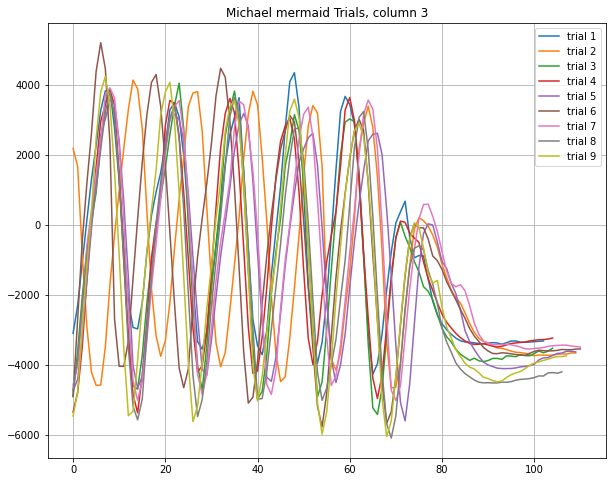

In [35]:
test_data_4 = pd.read_csv('w11_michael_1/mermaid.csv', index_col = False)
print(test_data_4.shape)

fig, ax = plt.subplots(figsize = [10,8])
for i in range(1,10):
    temp = test_data_4[test_data_4['0'] == i]
    x = [i for i in range(temp.shape[0])]
    ax.plot(x, temp['3'], label = f"trial {str(i)}")

plt.title('Michael mermaid Trials, column 3')
plt.legend()
ax.grid()
plt.show()

### Load ###

In [28]:
#start a new list
data_all_x_list = []
data_all_y_list = []

In [29]:
def load_csv(folders, ignore_dict=None):
    for filename in folders:
        label_name = filename.split('/')[-1].split('.')[0]
        #print(label_name)
        motion_df = pd.read_csv(filename, index_col = False)
        n_trials = motion_df['0'].max()
        #print(f"motion_df's shape is : {motion_df.shape}")
        for i in range(1, n_trials + 1):
            if (ignore_dict is not None) and (i in ignore_dict[label_name]):
                print(f"we skipped {i}")
                continue
            #print(f"we now work on {i}")
            df = motion_df[motion_df['0'] == i].copy()
    #         drop_columns = list(set(df.columns) - set(usr_cols))
            df.drop(columns = drop_cols, inplace = True)
            length = df.shape[0]
            #print(f"initial shape {df.shape}")
            if length < window:
                skip_c += 1
                continue
            # We cut the ending part, if we don't have enough, we dont cut
            cut_size = min(cut_size_cand, length - window)
            length -= cut_size
            df = df[0:length]
            #print(f"shape after cut tail: {df.shape}")    
            # We apply EMA filter here
            if ema:
                df = df.ewm(com = com).mean()
            if sma:
                df = df.rolling(window = sma_window).mean()
            #sliding window
            win_count = 1
            win_count += int((length - window)/ distinct_in_overlap)
            #print(win_count)
            data_x = np.zeros((win_count, window, df.shape[1]))
            data_y = np.zeros(win_count)
            for c in range(win_count):
                start_idx = int(c * distinct_in_overlap)
                end_idx = start_idx + window
                #print(df[start_idx:end_idx].shape)
                data_x[c,:,:] = df[start_idx:end_idx].values
                data_y[:] = activity_codes[label_name]
            data_all_x_list.append(data_x)
            data_all_y_list.append(data_y) 

In [30]:
#joshua_1
#We ignore the first trial for all three moves
data_folder_path = 'w11_joshua_1'
folders = glob(os.path.join(data_folder_path,'*.csv'))
ignore_dict = {'mermaid':[1],'jamesbond':[1],'dab':[1]}
load_csv(folders, ignore_dict)
print(len(data_all_x_list))
print(len(data_all_y_list))

we skipped 1
we skipped 1
we skipped 1
150
150


In [31]:
#joshua_2
#We do not ignore anything among these 5. Check whether trial 1 is ok or not.
data_folder_path = 'w11_joshua_2'
folders = glob(os.path.join(data_folder_path,'*.csv'))
load_csv(folders)
print(len(data_all_x_list))
print(len(data_all_y_list))

165
165


In [32]:
#sanath_1
#Note:
#Ignore samples 12, 27, 51 and 52 for mermaid_sanath.csv
#Ignore sample 50 for jamesbond_sanath.csv
data_folder_path = 'w11_sanath_1'
folders = glob(os.path.join(data_folder_path,'*.csv'))
ignore_dict = {'mermaid':[12,27,51,52],'jamesbond':[50],'dab':[]}
load_csv(folders, ignore_dict)
print(len(data_all_x_list))
print(len(data_all_y_list))

we skipped 50
we skipped 12
we skipped 27
we skipped 51
we skipped 52
315
315


In [36]:
#michael_1
#Note: No need ignore any trial
data_folder_path = 'w11_michael_1'
folders = glob(os.path.join(data_folder_path,'*.csv'))
load_csv(folders)
print(len(data_all_x_list))
print(len(data_all_y_list))

468
468


In [37]:
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape) 
print(f"we skipped {skip_c} trials")

(2787, 40, 6)
(2787,)
we skipped 0 trials


In [38]:
count_mermaid = 0
count_jamesbond = 0
count_dab = 0
for i in data_all_y:
    if i == 0:
        count_mermaid += 1
    elif i == 1:
        count_jamesbond += 1
    elif i == 2:
        count_dab += 1
    else:
        print("you are not a member of the family")
print(f"mermaid: {count_mermaid}, jamesbond: {count_jamesbond}, dab: {count_dab}")

mermaid: 796, jamesbond: 871, dab: 1120


## What about dirrectly train with CNN? ##

In [183]:
train_x_temp,test_x,train_y_temp,test_y = train_test_split(data_all_x,data_all_y,test_size=0.2)
train_x,val_x,train_y,val_y = train_test_split(train_x_temp,train_y_temp,test_size=0.1)
assert(len(train_x) == len(train_y))
print(len(train_x), len(test_x),len(val_x))

2165 602 241


In [184]:
# Save test file to be test in ultra96 with tflite
print(test_x[20].shape)
_label = test_y[20]
print(_label)
with open('test_single_y.txt', 'w') as f:
    f.write('%d' % _label)
pd.DataFrame(test_x[20]).to_csv("test_single_x.csv", index = False)
#pd.DataFrame(test_y[100]).to_csv("test_single_y.csv")

(40, 6)
1


In [185]:
num_classes = 3
input_shape = (window, 6)
# val_y = np.asarray(val_y).astype('float32').reshape((-1,1))
# train_y = np.asarray(train_y).astype('float32').reshape((-1,1))
# test_y = np.asarray(test_y).astype('float32').reshape((-1,1))
train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
val_x = tf.convert_to_tensor(val_x, dtype=tf.float32)
train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(train_y,  num_classes=num_classes), dtype=tf.float32)
test_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=num_classes), dtype=tf.float32)
val_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(val_y,  num_classes=num_classes), dtype=tf.float32)

In [186]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

In [187]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [188]:
for i,j in val_dataset.take(1):
    print(i.numpy().shape)
    print(j.numpy().shape)

(16, 40, 6)
(16, 3)


In [189]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = input_shape),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Flatten(input_shape = input_shape),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_195 (Conv1D)          (None, 38, 32)            608       
_________________________________________________________________
max_pooling1d_195 (MaxPoolin (None, 19, 32)            0         
_________________________________________________________________
conv1d_196 (Conv1D)          (None, 17, 32)            3104      
_________________________________________________________________
max_pooling1d_196 (MaxPoolin (None, 9, 32)             0         
_________________________________________________________________
conv1d_197 (Conv1D)          (None, 7, 32)             3104      
_________________________________________________________________
max_pooling1d_197 (MaxPoolin (None, 4, 32)             0         
_________________________________________________________________
flatten_65 (Flatten)         (None, 128)             

In [190]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [191]:
epochs = 50
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/50
136/136 [==============================] - 2s 6ms/step - loss: 1.1037 - accuracy: 0.3991 - val_loss: 0.9866 - val_accuracy: 0.5394
Epoch 2/50
136/136 [==============================] - 0s 4ms/step - loss: 1.0507 - accuracy: 0.4457 - val_loss: 0.9952 - val_accuracy: 0.4440
Epoch 3/50
136/136 [==============================] - 0s 4ms/step - loss: 1.0211 - accuracy: 0.4545 - val_loss: 0.9574 - val_accuracy: 0.4606
Epoch 4/50
136/136 [==============================] - 0s 4ms/step - loss: 0.9864 - accuracy: 0.4730 - val_loss: 0.9204 - val_accuracy: 0.5436
Epoch 5/50
136/136 [==============================] - 1s 4ms/step - loss: 0.9794 - accuracy: 0.4822 - val_loss: 0.9493 - val_accuracy: 0.4523
Epoch 6/50
136/136 [==============================] - 1s 4ms/step - loss: 1.0387 - accuracy: 0.4564 - val_loss: 1.0087 - val_accuracy: 0.4149
Epoch 7/50
136/136 [==============================] - 0s 4ms/step - loss: 1.0533 - accuracy: 0.4162 - val_loss: 0.9517 - val_accuracy: 0.4564
Epoch 

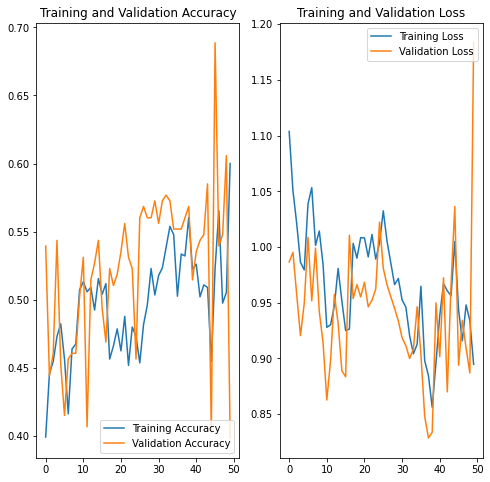

In [192]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [193]:
print(f"best training accruacy:{max(history.history['accuracy'])}")
print(f"best validation accruacy:{max(history.history['val_accuracy'])}")

best training accruacy:0.6000000238418579
best validation accruacy:0.6887966990470886


In [37]:
# model.save('boing_cnn.h5')

In [194]:
model.evaluate(test_dataset,batch_size = BATCH_SIZE)

38/38 [==============================] - 0s 2ms/step - loss: 1.1129 - accuracy: 0.4352


[1.1129435300827026, 0.43521595001220703]

## What about K-fold cross validation? ##

In [53]:
# train_x,test_x,train_y,test_y = train_test_split(data_all_x,data_all_y,test_size=0.15)
# assert(len(train_x) == len(train_y))
# assert(len(test_x) == len(test_y))
# print(train_x.shape, test_x.shape)
# print(train_y.shape, test_y.shape)

#how about we dont test? Just use K-fold cross validation, for train and val, and select the best
train_x = data_all_x
train_y = data_all_y
print(train_x.shape)
print(train_y.shape)

(2787, 40, 6)
(2787,)


In [54]:
# Save test file to be test in ultra96 with tflite
# print(test_x[20].shape)
# _label = test_y[20]
# print(_label)
# with open(f"test_single_y_{window}.txt", 'w') as f:
#     f.write('%d' % _label)
# pd.DataFrame(test_x[20]).to_csv(f"test_single_x_{window}.csv", index = False)

In [55]:
kfold = KFold(n_splits=10, shuffle=True)

In [56]:
num_classes = 3
num_features = 6
batch_size = 16
acc_list = {}
f1_list = {}
train_acc_list = {}
fold_no = 1
epochs = 15
best_id = 1
best_acc = 0
best_f1_macro = 0
input_shape = (window,6)
save_path = os.path.join(os.getcwd(), 'temp_models')
print_frequency = 15

for train, test in tqdm(kfold.split(train_x, train_y)):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = input_shape),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Flatten(input_shape = input_shape),
        tf.keras.layers.Dense(64, activation='sigmoid'),
#         tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes)
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    _train_x = train_x[train]
    _train_y = train_y[train]
    _val_x = train_x[test]
    _val_y = train_y[test]
#     print(_train_x.shape)
#     print(_train_y.shape)
#     print(_val_x.shape)
#     print(_val_y.shape)
    length_train = _train_x.shape[0]
    length_val = _val_x.shape[0]
    _train_x = tf.convert_to_tensor(_train_x, dtype=tf.float32)
    _val_x = tf.convert_to_tensor(_val_x, dtype=tf.float32)
    #If feature extraction is used, then the input is 1d array, we need re format for cnn
#     _train_x = tf.reshape(_train_x, (length_train, num_features, 1))
#     _val_x = tf.reshape(_val_x, (length_val, num_features, 1))
    _train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(_train_y,  num_classes=num_classes), dtype=tf.float32)
    _val_y_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(_val_y,  num_classes= num_classes), dtype=tf.float32)
#     _train_dataset = tf.data.Dataset.from_tensor_slices((_train_x, _train_y))
#     _val_dataset = tf.data.Dataset.from_tensor_slices((_val_x, _val_y))
    history = model.fit(
        _train_x,
        _train_y,
        epochs=epochs,
        verbose=0
    )
    train_acc = history.history['accuracy']
    print(f"===Highest training accuracy for fold {fold_no}: {max(train_acc)}===")
#     loss, accuracy, f1_score, precision, recall = model.evaluate(_val_x, _val_y_1, verbose=0)
#     print(f"===loss:{loss}, accuracy:{accuracy}, precision:{precision}, recall:{recall}, f1_score:{f1_score}")
    y_pred = model.predict(_val_x, verbose=0)
#     print(y_pred)
    y_pred_1 = np.argmax(y_pred, axis = 1)
#     print(y_pred_1)
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
    f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
    acc_metric = tf.keras.metrics.Accuracy()
    #acc_metric.update_state(train_y[test], y_pred_1)
    acc_metric.update_state(_val_y, y_pred_1)
    acc = acc_metric.result().numpy()
    # print(acc)
    #y_pred_1 = y_pred_1.astype(np.float32)
    #f1_metric.update_state(train_y_1, y_pred)
    f1_metric.update_state(_val_y_1, y_pred)
    f1_macro = f1_metric.result().numpy()
    if acc > best_acc:
        best_acc = acc
        best_f1_macro = f1_macro
        best_id = fold_no
    # print(f1_macro)
    print(f"===Validation accuracy for fold {fold_no}: {acc}; f1_macro is {f1_macro}===")
    acc_list[fold_no] = acc
    train_acc_list[fold_no] = train_acc
    f1_list[fold_no] = f1_macro
    model.save(os.path.join(save_path, f"cnn_kfold_fold{fold_no}.h5"))
    fold_no += 1
print(f"=== K fold cv completed, Best model occured at fold {best_id}, with accuracy {best_acc}, f1 macro {best_f1_macro}===")

0it [00:00, ?it/s]

===Highest training accuracy for fold 1: 0.779106855392456===
===Validation accuracy for fold 1: 0.7204301357269287; f1_macro is 0.66748046875===
===Highest training accuracy for fold 2: 0.8480861186981201===
===Validation accuracy for fold 2: 0.842293918132782; f1_macro is 0.8170910477638245===
===Highest training accuracy for fold 3: 0.8544657230377197===
===Validation accuracy for fold 3: 0.8530465960502625; f1_macro is 0.8488640785217285===
===Highest training accuracy for fold 4: 0.7583732008934021===
===Validation accuracy for fold 4: 0.7849462628364563; f1_macro is 0.7558690905570984===
===Highest training accuracy for fold 5: 0.8608452677726746===
===Validation accuracy for fold 5: 0.8781362175941467; f1_macro is 0.876347541809082===
===Highest training accuracy for fold 6: 0.8644338250160217===
===Validation accuracy for fold 6: 0.8136200904846191; f1_macro is 0.8029170632362366===
===Highest training accuracy for fold 7: 0.8213716149330139===
===Validation accuracy for fold 7

In [171]:
length_test= test_x.shape[0]
test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
#Again, we conly need below line if feature extraction is used
#test_x = tf.reshape(test_x, (length_test, num_features, 1))
test_y_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=num_classes), dtype=tf.float32)
best_model = tf.keras.models.load_model(os.path.join(save_path, f"cnn_kfold_fold{best_id}.h5"))
y_pred = best_model.predict(test_x, verbose=0)
#     print(y_pred)
y_pred_1 = np.argmax(y_pred, axis = 1)
#     print(y_pred_1)
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
acc_metric = tf.keras.metrics.Accuracy()
#acc_metric.update_state(train_y[test], y_pred_1)
acc_metric.update_state(test_y, y_pred_1)
acc = acc_metric.result().numpy()
# print(acc)
#y_pred_1 = y_pred_1.astype(np.float32)
#f1_metric.update_state(train_y_1, y_pred)
f1_metric.update_state(test_y_1, y_pred)
f1_macro = f1_metric.result().numpy()
print(f"test accuracy is {acc}")
print(f"test f1 macro is {f1_macro}")

test accuracy is 0.9181416034698486
test f1 macro is 0.9223744869232178


In [44]:
print(best_id)

8


In [59]:
best_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 38, 32)            608       
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 19, 32)            0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 17, 32)            3104      
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 8, 32)             0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 6, 32)             3104      
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 3, 32)             0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 96)              

## What about feature extraction? ##

### load dataset using feature extraction ###

In [88]:
data_all_x_list = []
data_all_y_list = []
for filename in folders:
    label_name = filename.split('/')[-1].split('.')[0]
    print(label_name)
    motion_df = pd.read_csv(os.path.join(data_folder_path, filename), index_col = False)
    #print(f"motion_df's shape is : {motion_df.shape}")
    for i in range(2, 1 + n_trials):
        df = motion_df[motion_df['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
        df.drop(columns = drop_cols, inplace = True)
        length = df.shape[0]
        #print(df.shape)
        if length < window:
            skip_c += 1
            continue
        # We cut the ending part, if we don't have enough, we dont cut
        cut_size = min(int(frequency / 2), length - window)
        length -= cut_size
        df = df[0:length]
        # We apply EMA filter here
        if ema:
            df = df.ewm(com = com).mean()
        #sliding window
        win_count = 1
        win_count += int((length - window)/ distinct_in_overlap)
        #print(win_count)
        data_x = np.zeros((win_count, df.shape[1] * 5))
        data_y = np.zeros(win_count)
        for c in range(win_count):
            start_idx = int(c * distinct_in_overlap)
            end_idx = start_idx + window
            temp_list = []
            for k in range(1, 1 + feature_n):
                means = df[start_idx:end_idx][str(k)].mean()
                stds = df[start_idx:end_idx][str(k)].mean()
                mins = df[start_idx:end_idx][str(k)].min()
                maxs = df[start_idx:end_idx][str(k)].max()
                mads = df[start_idx:end_idx][str(k)].mad()
                temp_list.append(means)
                temp_list.append(stds)
                temp_list.append(mins)
                temp_list.append(maxs)
                temp_list.append(mads)
            data_x[c] = temp_list
            data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y) 

#Second part of the data, some are interrupted at the middle
# For dab
dab_2 = os.path.join(data_folder_path_2, 'dab.csv')
label_name = dab_2.split('/')[-1].split('.')[0]
print(label_name)
dab_df = pd.read_csv(dab_2, index_col = False)
#print(list(dab_df.columns))
dab_df_1 = dab_df[dab_df['Unnamed: 0'] <= 1353]
dab_df_2 = dab_df[dab_df['Unnamed: 0'] > 1353]

for i in range(2, 20):
    df = dab_df_1[dab_df_1['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
    df.drop(columns = drop_cols, inplace = True)
    length = df.shape[0]
    if length < window:
        skip_c += 1
        continue
    #print(df.shape)
    # We cut the ending part, if we don't have enough, we dont cut
    cut_size = min(int(frequency / 2), length - window)
    length -= cut_size
    df = df[0:length]
    #print(f"shape after cut tail: {df.shape}")
    # We apply EMA filter here
    if ema:
        df = df.ewm(com = com).mean()
    #sliding window
    win_count = 1
    win_count += int((length - window)/ distinct_in_overlap)
    #print(win_count)
    data_x = np.zeros((win_count, df.shape[1] * 5))
    data_y = np.zeros(win_count)
    for c in range(win_count):
        start_idx = int(c * distinct_in_overlap)
        end_idx = start_idx + window
        temp_list = []
        for k in range(1, 1 + feature_n):
            means = df[start_idx:end_idx][str(k)].mean()
            stds = df[start_idx:end_idx][str(k)].mean()
            mins = df[start_idx:end_idx][str(k)].min()
            maxs = df[start_idx:end_idx][str(k)].max()
            mads = df[start_idx:end_idx][str(k)].mad()
            temp_list.append(means)
            temp_list.append(stds)
            temp_list.append(mins)
            temp_list.append(maxs)
            temp_list.append(mads)
        data_x[c] = temp_list
        data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
    data_all_x_list.append(data_x)
    data_all_y_list.append(data_y)
    
for i in range(2, 51):
    df = dab_df_2[dab_df_2['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
    df.drop(columns = drop_cols, inplace = True)
    length = df.shape[0]
    if length < window:
        skip_c += 1
        continue
    #print(df.shape)
    # We cut the ending part, if we don't have enough, we dont cut
    cut_size = min(int(frequency / 2), length - window)
    length -= cut_size
    df = df[0:length]
    #print(f"shape after cut tail: {df.shape}")
    # We apply EMA filter here
    if ema:
        df = df.ewm(com = com).mean()
    #sliding window
    win_count = 1
    win_count += int((length - window)/ distinct_in_overlap)
    #print(win_count)
    data_x = np.zeros((win_count, df.shape[1] * 5))
    data_y = np.zeros(win_count)
    for c in range(win_count):
        start_idx = int(c * distinct_in_overlap)
        end_idx = start_idx + window
        temp_list = []
        for k in range(1, 1 + feature_n):
            means = df[start_idx:end_idx][str(k)].mean()
            stds = df[start_idx:end_idx][str(k)].mean()
            mins = df[start_idx:end_idx][str(k)].min()
            maxs = df[start_idx:end_idx][str(k)].max()
            mads = df[start_idx:end_idx][str(k)].mad()
            temp_list.append(means)
            temp_list.append(stds)
            temp_list.append(mins)
            temp_list.append(maxs)
            temp_list.append(mads)
        data_x[c] = temp_list
        data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
    data_all_x_list.append(data_x)
    data_all_y_list.append(data_y)

# For jamesbond
jamesbond_2 = os.path.join(data_folder_path_2, 'jamesbond.csv')
label_name = jamesbond_2.split('/')[-1].split('.')[0]
print(label_name)
jamesbond_df = pd.read_csv(jamesbond_2, index_col = False)
#print(list(jamesbond_df.columns))
jamesbond_df_1 = jamesbond_df[jamesbond_df['Unnamed: 0'] <= 3289]
jamesbond_df_2 = jamesbond_df[jamesbond_df['Unnamed: 0'] > 3289]
for i in range(2, 46):
    df = jamesbond_df_1[jamesbond_df_1['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
    df.drop(columns = drop_cols, inplace = True)
    length = df.shape[0]
    if length < window:
        skip_c += 1
        continue
    #print(df.shape)
    # We cut the ending part, if we don't have enough, we dont cut
    cut_size = min(int(frequency / 2), length - window)
    length -= cut_size
    df = df[0:length]
    #print(f"shape after cut tail: {df.shape}")
    # We apply EMA filter here
    if ema:
        df = df.ewm(com = com).mean()
    #sliding window
    win_count = 1
    win_count += int((length - window)/ distinct_in_overlap)
    #print(win_count)
    data_x = np.zeros((win_count, df.shape[1] * 5))
    data_y = np.zeros(win_count)
    for c in range(win_count):
        start_idx = int(c * distinct_in_overlap)
        end_idx = start_idx + window
        temp_list = []
        for k in range(1, 1 + feature_n):
            means = df[start_idx:end_idx][str(k)].mean()
            stds = df[start_idx:end_idx][str(k)].mean()
            mins = df[start_idx:end_idx][str(k)].min()
            maxs = df[start_idx:end_idx][str(k)].max()
            mads = df[start_idx:end_idx][str(k)].mad()
            temp_list.append(means)
            temp_list.append(stds)
            temp_list.append(mins)
            temp_list.append(maxs)
            temp_list.append(mads)
        data_x[c] = temp_list
        data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
    data_all_x_list.append(data_x)
    data_all_y_list.append(data_y)
    
for i in range(2, 8):
    df = jamesbond_df_2[jamesbond_df_2['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
    df.drop(columns = drop_cols, inplace = True)
    length = df.shape[0]
    if length < window:
        skip_c += 1
        continue
    #print(df.shape)
    # We cut the ending part, if we don't have enough, we dont cut
    cut_size = min(int(frequency / 2), length - window)
    length -= cut_size
    df = df[0:length]
    #print(f"shape after cut tail: {df.shape}")
    # We apply EMA filter here
    if ema:
        df = df.ewm(com = com).mean()
    #sliding window
    win_count = 1
    win_count += int((length - window)/ distinct_in_overlap)
    #print(win_count)
    data_x = np.zeros((win_count, df.shape[1] * 5))
    data_y = np.zeros(win_count)
    for c in range(win_count):
        start_idx = int(c * distinct_in_overlap)
        end_idx = start_idx + window
        temp_list = []
        for k in range(1, 1 + feature_n):
            means = df[start_idx:end_idx][str(k)].mean()
            stds = df[start_idx:end_idx][str(k)].mean()
            mins = df[start_idx:end_idx][str(k)].min()
            maxs = df[start_idx:end_idx][str(k)].max()
            mads = df[start_idx:end_idx][str(k)].mad()
            temp_list.append(means)
            temp_list.append(stds)
            temp_list.append(mins)
            temp_list.append(maxs)
            temp_list.append(mads)
        data_x[c] = temp_list
        data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
    data_all_x_list.append(data_x)
    data_all_y_list.append(data_y)

# for mermaid
mermaid_2 = os.path.join(data_folder_path_2, 'mermaid.csv')
label_name = mermaid_2.split('/')[-1].split('.')[0]
print(label_name)
mermaid_df = pd.read_csv(mermaid_2, index_col = False)
#print(list(mermaid_df.columns))
for i in range(2, 49):
    df = mermaid_df[mermaid_df['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
    df.drop(columns = drop_cols, inplace = True)
    length = df.shape[0]
    if length < window:
        skip_c += 1
        continue
    #print(df.shape)
    # We cut the ending part, if we don't have enough, we dont cut
    cut_size = min(int(frequency / 2), length - window)
    length -= cut_size
    df = df[0:length]
    #print(f"shape after cut tail: {df.shape}")
    # We apply EMA filter here
    if ema:
        df = df.ewm(com = com).mean()
    #sliding window
    win_count = 1
    win_count += int((length - window)/ distinct_in_overlap)
    #print(win_count)
    data_x = np.zeros((win_count, df.shape[1] * 5))
    data_y = np.zeros(win_count)
    for c in range(win_count):
        start_idx = int(c * distinct_in_overlap)
        end_idx = start_idx + window
        temp_list = []
        for k in range(1, 1 + feature_n):
            means = df[start_idx:end_idx][str(k)].mean()
            stds = df[start_idx:end_idx][str(k)].mean()
            mins = df[start_idx:end_idx][str(k)].min()
            maxs = df[start_idx:end_idx][str(k)].max()
            mads = df[start_idx:end_idx][str(k)].mad()
            temp_list.append(means)
            temp_list.append(stds)
            temp_list.append(mins)
            temp_list.append(maxs)
            temp_list.append(mads)
        data_x[c] = temp_list
        data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
    data_all_x_list.append(data_x)
    data_all_y_list.append(data_y)

n_trials = 51
for filename in folders_3:
    label_name = filename.split('/')[-1].split('.')[0]
    print(label_name)
    motion_df = pd.read_csv(os.path.join(data_folder_path_3, filename), index_col = False)
    #print(f"{label_name} df shape is : {motion_df.shape}")
    for i in range(2, 1 + n_trials):
        df = motion_df[motion_df['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
        df.drop(columns = drop_cols, inplace = True)
        length = df.shape[0]
        #print(df.shape)
        if length < window:
            skip_c += 1
            continue
        # We cut the tail, if we don't have enough, we dont cut
        cut_size = min(int(frequency / 2), length - window)
        length -= cut_size
        df = df[0:length]
        #print(f"shape after cut tail: {df.shape}")
        # We apply EMA filter here
        if ema:
            df = df.ewm(com = com).mean()
        #sliding window
        win_count = 1
        win_count += int((length - window)/ distinct_in_overlap)
        #print(f"we have {win_count} window for trail {i}")
        data_x = np.zeros((win_count, df.shape[1] * 5))
        data_y = np.zeros(win_count)
        for c in range(win_count):
            start_idx = int(c * distinct_in_overlap)
            end_idx = start_idx + window
            temp_list = []
            for k in range(1, 1 + feature_n):
                means = df[start_idx:end_idx][str(k)].mean()
                stds = df[start_idx:end_idx][str(k)].mean()
                mins = df[start_idx:end_idx][str(k)].min()
                maxs = df[start_idx:end_idx][str(k)].max()
                mads = df[start_idx:end_idx][str(k)].mad()
                temp_list.append(means)
                temp_list.append(stds)
                temp_list.append(mins)
                temp_list.append(maxs)
                temp_list.append(mads)
            data_x[c] = temp_list
            data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)

# Part 4
for filename in folders_4:
    label_name = filename.split('/')[-1].split('.')[0]
    if label_name == 'mermaid_2':
        label_name = 'mermaid'
    print(label_name)
    motion_df = pd.read_csv(os.path.join(data_folder_path_4, filename), index_col = False)
    #print(f"{label_name} df shape is : {motion_df.shape}")
    n_trials = motion_df['0'].max()
    print(n_trials)
    for i in range(2, 1 + n_trials):
        df = motion_df[motion_df['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
        df.drop(columns = drop_cols, inplace = True)
        length = df.shape[0]
        #print(df.shape)
        if length < window:
            skip_c += 1
            continue
        # We cut the tail, if we don't have enough, we dont cut
        cut_size = min(int(frequency / 2), length - window)
        length -= cut_size
        df = df[0:length]
        #print(f"shape after cut tail: {df.shape}")
        # We apply EMA filter here
        if ema:
            df = df.ewm(com = com).mean()
        #sliding window
        win_count = 1
        win_count += int((length - window)/ distinct_in_overlap)
        #print(f"we have {win_count} window for trail {i}")
        data_x = np.zeros((win_count, df.shape[1] * 5))
        data_y = np.zeros(win_count)
        for c in range(win_count):
            start_idx = int(c * distinct_in_overlap)
            end_idx = start_idx + window
            temp_list = []
            for k in range(1, 1 + feature_n):
                means = df[start_idx:end_idx][str(k)].mean()
                stds = df[start_idx:end_idx][str(k)].mean()
                mins = df[start_idx:end_idx][str(k)].min()
                maxs = df[start_idx:end_idx][str(k)].max()
                mads = df[start_idx:end_idx][str(k)].mad()
                temp_list.append(means)
                temp_list.append(stds)
                temp_list.append(mins)
                temp_list.append(maxs)
                temp_list.append(mads)
            data_x[c] = temp_list
            data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)

dab
jamesbond
mermaid
dab
jamesbond
mermaid
dab
jamesbond
mermaid
dab
51
jamesbond
51
mermaid
20
mermaid
35


In [89]:
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape)

(3481, 30)
(3481,)


In [90]:
count_mermaid = 0
count_jamesbond = 0
count_dab = 0
for i in data_all_y:
    if i == 0:
        count_mermaid += 1
    elif i == 1:
        count_jamesbond += 1
    elif i == 2:
        count_dab += 1
    else:
        print("you are not a member of the family")
print(f"mermaid: {count_mermaid}, jamesbond: {count_jamesbond}, dab: {count_dab}")

mermaid: 993, jamesbond: 1235, dab: 1253


### Train with K-fold since K-fold performs better ###

In [91]:
train_x,test_x,train_y,test_y = train_test_split(data_all_x,data_all_y,test_size=0.2)
assert(len(train_x) == len(train_y))
assert(len(test_x) == len(test_y))
print(train_x.shape, test_x.shape)
print(train_y.shape, test_y.shape)

(2784, 30) (697, 30)
(2784,) (697,)


In [92]:
# Save test file to be test in ultra96 with tflite
print(test_x[20].shape)
_label = test_y[20]
print(_label)
with open('test_single_y.txt', 'w') as f:
    f.write('%d' % _label)
pd.DataFrame(test_x[20]).to_csv("test_single_x.csv", index = False)
#pd.DataFrame(test_y[100]).to_csv("test_single_y.csv")

(30,)
2


In [93]:
kfold = KFold(n_splits=5, shuffle=True)

In [94]:
num_classes = 3
num_features = 30
batch_size = 16
acc_list = {}
f1_list = {}
train_acc_list = {}
fold_no = 1
epochs = 20
best_id = 1
best_acc = 0
input_shape = (num_features, 1)
save_path = os.path.join(os.getcwd(), 'temp_models')

for train, test in tqdm(kfold.split(train_x, train_y)):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = input_shape),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Flatten(input_shape = input_shape),
        tf.keras.layers.Dense(64, activation='sigmoid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes)
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    _train_x = train_x[train]
    _train_y = train_y[train]
    _val_x = train_x[test]
    _val_y = train_y[test]
#     print(_train_x.shape)
#     print(_train_y.shape)
#     print(_val_x.shape)
#     print(_val_y.shape)
    length_train = _train_x.shape[0]
    length_val = _val_x.shape[0]
    _train_x = tf.convert_to_tensor(_train_x, dtype=tf.float32)
    _val_x = tf.convert_to_tensor(_val_x, dtype=tf.float32)
    #If feature extraction is used, then the input is 1d array, we need re format for cnn
    _train_x = tf.reshape(_train_x, (length_train, num_features, 1))
    _val_x = tf.reshape(_val_x, (length_val, num_features, 1))
    _train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(_train_y,  num_classes=num_classes), dtype=tf.float32)
    _val_y_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(_val_y,  num_classes= num_classes), dtype=tf.float32)
#     _train_dataset = tf.data.Dataset.from_tensor_slices((_train_x, _train_y))
#     _val_dataset = tf.data.Dataset.from_tensor_slices((_val_x, _val_y))
    history = model.fit(
        _train_x,
        _train_y,
        epochs=epochs
    )
    train_acc = history.history['accuracy']
    print(f"===Highest training accuracy: {max(train_acc)}===")
#     loss, accuracy, f1_score, precision, recall = model.evaluate(_val_x, _val_y_1, verbose=0)
#     print(f"===loss:{loss}, accuracy:{accuracy}, precision:{precision}, recall:{recall}, f1_score:{f1_score}")
    y_pred = model.predict(_val_x, verbose=0)
#     print(y_pred)
    y_pred_1 = np.argmax(y_pred, axis = 1)
#     print(y_pred_1)
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
    f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
    acc_metric = tf.keras.metrics.Accuracy()
    #acc_metric.update_state(train_y[test], y_pred_1)
    acc_metric.update_state(_val_y, y_pred_1)
    acc = acc_metric.result().numpy()
    # print(acc)
    #y_pred_1 = y_pred_1.astype(np.float32)
    #f1_metric.update_state(train_y_1, y_pred)
    f1_metric.update_state(_val_y_1, y_pred)
    f1_macro = f1_metric.result().numpy()
    if acc > best_acc:
        best_acc = acc
        best_id = fold_no
    # print(f1_macro)
    print(f"===Validation accuracy for fold {fold_no}: {acc}; f1_macro is {f1_macro}===")
    acc_list[fold_no] = acc
    train_acc_list[fold_no] = train_acc
    f1_list[fold_no] = f1_macro
    model.save(os.path.join(save_path, f"cnn_kfold_fold{fold_no}.h5"))
    fold_no += 1

0it [00:00, ?it/s]

Epoch 1/20
70/70 [==============================] - 1s 3ms/step - loss: 1.0399 - accuracy: 0.4589
Epoch 2/20
70/70 [==============================] - 0s 2ms/step - loss: 0.8984 - accuracy: 0.5276
Epoch 3/20
70/70 [==============================] - 0s 3ms/step - loss: 0.9085 - accuracy: 0.5335
Epoch 4/20
70/70 [==============================] - 0s 2ms/step - loss: 0.9303 - accuracy: 0.5245
Epoch 5/20
70/70 [==============================] - 0s 3ms/step - loss: 0.8231 - accuracy: 0.5905
Epoch 6/20
70/70 [==============================] - 0s 3ms/step - loss: 0.8256 - accuracy: 0.5784
Epoch 7/20
70/70 [==============================] - 0s 2ms/step - loss: 0.9748 - accuracy: 0.5065
Epoch 8/20
70/70 [==============================] - 0s 3ms/step - loss: 0.9600 - accuracy: 0.4912
Epoch 9/20
70/70 [==============================] - 0s 3ms/step - loss: 0.8187 - accuracy: 0.6062
Epoch 10/20
70/70 [==============================] - 0s 3ms/step - loss: 0.7759 - accuracy: 0.6304
Epoch 11/20
70/70 [

In [95]:
length_test= test_x.shape[0]
test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
#Again, we conly need below line if feature extraction is used
test_x = tf.reshape(test_x, (length_test, num_features, 1))
test_y_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=num_classes), dtype=tf.float32)
best_model = tf.keras.models.load_model(os.path.join(save_path, f"cnn_kfold_fold{best_id}.h5"))
y_pred = best_model.predict(test_x, verbose=0)
#     print(y_pred)
y_pred_1 = np.argmax(y_pred, axis = 1)
#     print(y_pred_1)
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
acc_metric = tf.keras.metrics.Accuracy()
#acc_metric.update_state(train_y[test], y_pred_1)
acc_metric.update_state(test_y, y_pred_1)
acc = acc_metric.result().numpy()
# print(acc)
#y_pred_1 = y_pred_1.astype(np.float32)
#f1_metric.update_state(train_y_1, y_pred)
f1_metric.update_state(test_y_1, y_pred)
f1_macro = f1_metric.result().numpy()
print(f"test accuracy is {acc}")
print(f"test f1 macro is {f1_macro}")

test accuracy is 0.754662811756134
test f1 macro is 0.740018367767334


In [96]:
print(best_id)

3


In [97]:
best_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 28, 32)            128       
_________________________________________________________________
max_pooling1d_81 (MaxPooling (None, 14, 32)            0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 12, 32)            3104      
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 6, 32)             0         
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 4, 32)             3104      
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 2, 32)             0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 64)              

## Integration part ##
1. Save the model to tensorflow lite
2. Give the parameters to sanath
3. Note, we should turn on these hyperparameters: window (length), overlap, whether feature extraction is used, whether EMA is used, epoch number(not sure)
4. At the test end, we should vote base on 3 or 5 predictions

In [60]:
# Using or not using k-fold, the model name differ
# model.save('boing_cnn_tflite.h5')
feature_extraction = 'nofx'
print(f"boing_cnn_tflite_w{window}_o{overlap}_{feature_extraction}_{'ema' if ema else 'noema'}")
best_model.save(f"boing_cnn_tflite_w{window}_o{overlap}_{feature_extraction}_{'ema' if ema else 'noema'}.h5")
model_cnn_tflite= tf.keras.models.load_model(f"boing_cnn_tflite_w{window}_o{overlap}_{feature_extraction}_{'ema' if ema else 'noema'}.h5")
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_tflite)
tflite_model = converter.convert()
with open(f"boing_cnn_tflite_w{window}_o{overlap}_{feature_extraction}_{'ema' if ema else 'noema'}.tflite", 'wb') as f:
    f.write(tflite_model)

boing_cnn_tflite_w40_o75_nofx_ema
INFO:tensorflow:Assets written to: /var/folders/j5/8p7d3wls6rz_zgxtqcsldwkm0000gn/T/tmphji2td6u/assets


INFO:tensorflow:Assets written to: /var/folders/j5/8p7d3wls6rz_zgxtqcsldwkm0000gn/T/tmphji2td6u/assets
2021-10-13 21:45:30.348402: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-10-13 21:45:30.348517: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-10-13 21:45:30.350232: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.003ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2021-10-13 21:45:30.456059: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2021-10-13 21:45:30.456078: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.


In [61]:
# Different from noraml evluation, here we test the tflite file with a single input.
# if successful, the funciton can be moved to ultra96, we can call the ML model in ultra96.

# import tflite_runtime.interpreter as tflite
import time
from math import exp

def math_loser(input_data, model_path):
    interpreter = tf.lite.Interpreter(model_path= model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # check the type of the input tensor
    floating_model = input_details[0]['dtype'] == np.float32

    # NxHxWxC, H:1, W:2
    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]
    print(f"shape of the input required by model is {height}, {width}")
    input_data = np.reshape(input_data, (-1, height, width))
    print(f"shape of the input we passed in is {input_data.shape}")

    interpreter.set_tensor(input_details[0]['index'], input_data)

    start_time = time.time()
    interpreter.invoke()
    stop_time = time.time()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    print(f"initial prediction is {output_data}")
    
    results = np.squeeze(output_data)
    print(f"After squeeze it becomes {results}")
    sum_probability = exp(results[0]) + exp(results[1]) + exp(results[2])
    p1 = exp(results[0]) / sum_probability
    p2 = exp(results[1]) / sum_probability
    p3 = exp(results[2]) / sum_probability
    prob_list = [p1,p2,p3]
    print(prob_list)
    
    pred = np.argmax(results)
    print(f"After argmax it becomes {pred}")

    print('time used: {:.3f}ms'.format((stop_time - start_time) * 1000))
    return pred

In [62]:
with open(f"test_single_y_{window}.txt", 'r') as f:
    _y = f.readline().strip()
print(f"correct label: {_y}")
_input_data = pd.read_csv(f"test_single_x_{window}.csv", index_col=False)
# print(list(_input_data.columns))
if feature_extraction == 'fx':
    temp_list = []
    for k in range(0, feature_n):
        means = _input_data[str(k)].mean()
        stds = _input_data[str(k)].mean()
        mins = _input_data[str(k)].min()
        maxs = _input_data[str(k)].max()
        mads = _input_data[str(k)].mad()
        temp_list.append(means)
        temp_list.append(stds)
        temp_list.append(mins)
        temp_list.append(maxs)
        temp_list.append(mads)
    temp_list = np.array(temp_list)
    print(temp_list.shape)
    temp_list = temp_list.astype('float32')
    print(f"shape of the input we passed in initially is {temp_list.shape}")
    print(f"type of the input we passed in is {temp_list.dtype}")
    pred = math_loser(temp_list, f"boing_cnn_tflite_w{window}_o{overlap}_{feature_extraction}_{'ema' if ema else 'noema'}.tflite")
else:
    _input_data = _input_data.to_numpy()
    _input_data = _input_data.astype('float32')
    print(f"shape of the input we passed in initially is {_input_data.shape}")
    print(f"type of the input we passed in is {_input_data.dtype}")
    pred = math_loser(_input_data, f"boing_cnn_tflite_w{window}_o{overlap}_{feature_extraction}_{'ema' if ema else 'noema'}.tflite")

correct label: 0
shape of the input we passed in initially is (40, 6)
type of the input we passed in is float32
shape of the input required by model is 40, 6
shape of the input we passed in is (1, 40, 6)
initial prediction is [[ 2.80396   -4.044375  -1.0585507]]
After squeeze it becomes [ 2.80396   -4.044375  -1.0585507]
[0.9784004506038044, 0.001038299228442261, 0.02056125016775336]
After argmax it becomes 0
time used: 0.269ms


In [ ]:
def print_conv_kernel(np_arr):
    # Conv Layer (Kernel)
    print("{")
    first_3 = True
    for filter in np_arr:
        if first_3 == False:
            print(",", end="")
        first_3 = False
        print("{",end="")
        first = True
        for row in filter:
            if first == False:
                print(",", end="")
            print("{" , end="")
            first = False

            first_2 = True
            for val in row:
                if first_2 == False:
                    print(",", end="")
                print(val , end="")
                first_2 = False
            print("}")
        print("}")
        print()
    print("};")

def print_dense_layer_kernel(np_arr):
    # Dense Layer (Kernel)
    print("{")
    first_3 = True
    for filter in np_arr:
        if first_3 == False:
            print(",", end="")
        first_3 = False
        print("{",end="")
        first_2 = True
        for val in filter:
            if first_2 == False:
                print(",", end="")
            print(val , end="")
            first_2 = False
        print("}")
    print("};")
    
def print_bias(np_arr):
    # Bias (both conv & dense)
    print("{",end="")
    first = True
    for val in np_arr:
        if first == False:
            print(",",end="")
        first = False
        print(val,end="")
    print("};")

# Extract Conv Layer Weights
# Conv Layer 1
print_conv_kernel(best_model.trainable_weights[0].numpy())
print_bias(best_model.trainable_weights[1].numpy())

# Conv Layer 2
print_conv_kernel(best_model.trainable_weights[2].numpy())
print_bias(best_model.trainable_weights[3].numpy())

# Conv Layer 3
print_conv_kernel(best_model.trainable_weights[4].numpy())
print_bias(best_model.trainable_weights[5].numpy())

# Extract Dense Layer Weights
# Dense Layer 1
print_dense_layer_kernel(best_model.trainable_weights[6].numpy())
print_bias(best_model.trainable_weights[7].numpy())

# Dense Layer 2
print_dense_layer_kernel(best_model.trainable_weights[8].numpy())
print_bias(best_model.trainable_weights[9].numpy())

In [64]:
print(f"{window}_{overlap}_{'ema'if ema else 'noema'}_{feature_extraction}")

40_75_ema_nofx
